In [1]:
import numpy as np
import pandas as pd
import pickle
import warnings
import time
import re
import gspread
from oauth2client.service_account import ServiceAccountCredentials

#Graphs
import matplotlib.pyplot as plt
import seaborn as sns

#Sklearn tools
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor 
from sklearn import preprocessing 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

#pandas show all columns
pd.set_option('display.max_columns', None)
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# define the scope
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']

# add credentials to the account
creds = ServiceAccountCredentials.from_json_keyfile_name('useless-machine-learning-a9027a9eb367.json', scope)

# authorize the clientsheet 
gc = gspread.authorize(creds)

#Pull data from spreadsheet and conver to DataFrame
spreadsheet_key = '1SQpPGP0RYHR4KcOz4XoPFe5y4Mue9D6ilXaAld2dNrI'
book = gc.open_by_key(spreadsheet_key)
worksheet = book.worksheet("LCS Player Data")
bp_vals = worksheet.get_all_values()

bp = pd.DataFrame(bp_vals[1:], columns=bp_vals[0])

In [3]:
spring_2020 = bp[(bp['Split'] == 'Spring') & (bp['Year'] == '2020')].reset_index(drop = True)
summer_2020 = bp[(bp['Split'] == 'Summer') & (bp['Year'] == '2020')].reset_index(drop = True)
spring_2021 = bp[(bp['Split'] == 'Spring') & (bp['Year'] == '2021')].reset_index(drop = True)
summer_2021 = bp[(bp['Split'] == 'Summer') & (bp['Year'] == '2021')].reset_index(drop = True)

In [4]:
lcs_spring_2020 = pd.read_csv('LCS 2020 Spring - Player Stats - OraclesElixir.csv')
lcs_summer_2020 = pd.read_csv('LCS 2020 Summer - Player Stats - OraclesElixir.csv')
lcs_spring_2021 = pd.read_csv('LCS 2021 Spring - Player Stats - OraclesElixir.csv')
lcs_summer_2021 = pd.read_csv('LCS 2021 Summer - Player Stats - OraclesElixir.csv')

In [5]:
full_spring_2020 = spring_2020.merge(lcs_spring_2020, left_on= ['Name', 'Position'], right_on= ['Player', 'Pos'])
full_summer_2020 = summer_2020.merge(lcs_summer_2020, left_on= ['Name', 'Position'], right_on= ['Player', 'Pos'])
full_spring_2021 = spring_2021.merge(lcs_spring_2021, left_on= ['Name', 'Position'], right_on= ['Player', 'Pos'])
full_summer_2021 = summer_2021.merge(lcs_summer_2021, left_on= ['Name', 'Position'], right_on= ['Player', 'Pos'])

In [6]:
total = pd.concat([full_spring_2021, full_summer_2021, full_spring_2020, full_summer_2020], ignore_index=True)

In [7]:
total = total[['Name', 'Split', 'Year', 'Position', 'Rank', 'Player', 'GP', 'W%', 
                  'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
                  'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']].astype(str)

total['W%'] = total['W%'].str.replace('%', '').astype('float')
total['KS%'] = total['KS%'].str.replace('%', '').astype('float')
total['KP'] = total['KP'].str.replace('%', '').astype('float')
total['DTH%'] = total['DTH%'].str.replace('%', '').astype('float')
total['FB%'] = total['FB%'].str.replace('%', '').astype('float')
total['CS%P15'] = total['CS%P15'].str.replace('%', '').astype('float')
total['DMG%'] = total['DMG%'].str.replace('%', '').astype('float')
total['GOLD%'] = total['GOLD%'].str.replace('%', '').astype('float')

total[['Rank', 'GP', 'W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
      'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']] = total[['Rank', 'GP', 'W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
            'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']].astype('float')

In [8]:
total['K'] = total['K']/total['GP']
total['A'] = total['A']/total['GP']
total['D'] = total['D']/total['GP']
total.drop('GP', axis = 1, inplace = True)

In [9]:
sup = total[total['Position'] == 'Support']

features = ['W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
            'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']

### Correlation Matrix

In [10]:
regressor = RandomForestRegressor(n_estimators=500)

x_sup = sup[features].to_numpy()
y_sup = sup[['Rank']].to_numpy()
y_sup = y_sup.reshape(y_sup.shape[0], )
regressor.fit(x_sup, y_sup)
sup_ind = np.argsort(regressor.feature_importances_)[::-1]
for i in sup_ind:
    print(f"{features[i]}: {regressor.feature_importances_[i]:.4f}")

W%: 0.5262
KP: 0.1993
A: 0.0588
WPM: 0.0520
GD10: 0.0389
KS%: 0.0172
WCPM: 0.0134
D: 0.0126
K: 0.0108
XPD10: 0.0104
DPM: 0.0094
FB%: 0.0093
CSD10: 0.0077
EGPM: 0.0065
DTH%: 0.0063
CS%P15: 0.0052
DMG%: 0.0049
KDA: 0.0043
GOLD%: 0.0036
CSPM: 0.0032


<AxesSubplot:>

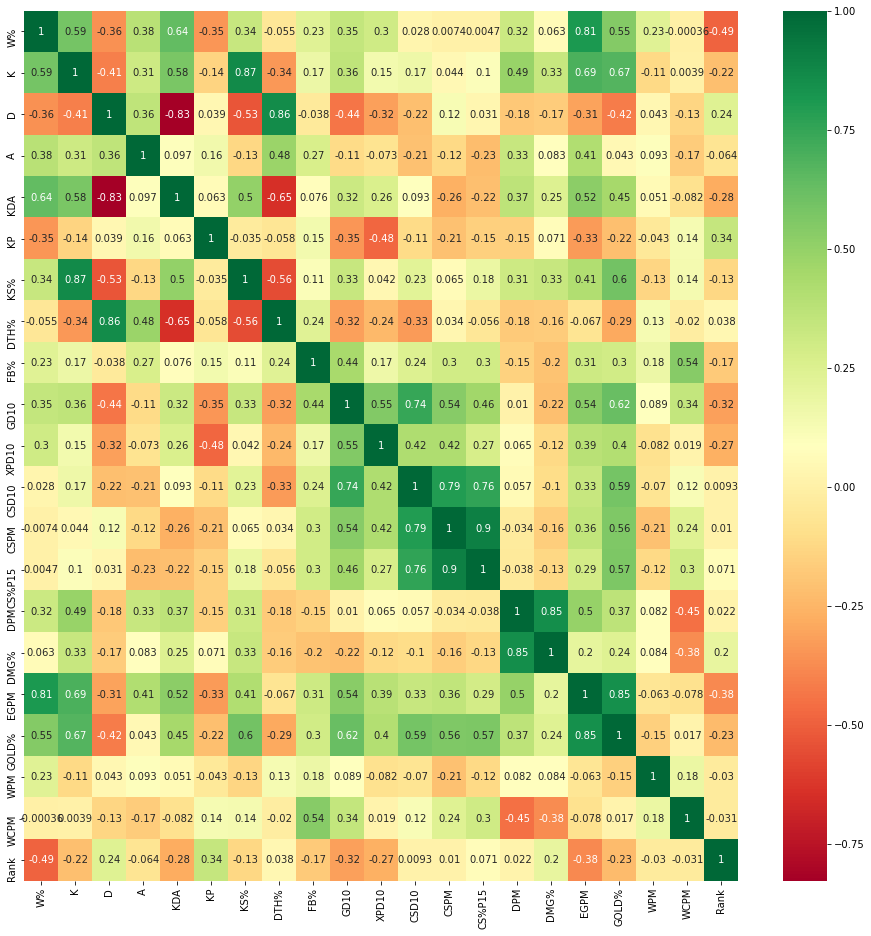

In [11]:
sup_corr = sup[features + ["Rank"]]

fig = plt.figure(figsize=(16, 16))
fig.set_facecolor('white')
sns.heatmap(sup_corr.corr(), annot=True, cmap="RdYlGn")

In [12]:
sup_features = ['W%', 'A', 'KP', 'WPM', 'WCPM', 'FB%']

In [13]:
means = []
for i in sup_features: 
    means.append(sup[i].mean())

for j, k in enumerate(sup_features): 
    sup.loc[:,k] = sup[k].apply(lambda x: (x - means[j])/means[j])

### Normalizing and train test splitting data

In [14]:
X_sup = sup[sup_features].values
y_sup = sup[['Rank']].values

PredictorScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X_sup)
 
# Generating the standardized values of X
X_sup = PredictorScalerFit.transform(X_sup)
 
# Split the data into training and testing set
X_train_sup, X_test_sup, y_train_sup, y_test_sup = train_test_split(X_sup, y_sup, test_size=0.3, random_state=42)

### Linear Regression Results

In [15]:
lin_regressor = LinearRegression()  
lin_regressor.fit(X_train_sup, y_train_sup)
lin_pred = lin_regressor.predict(X_test_sup)
df1 = pd.DataFrame({'Actual': y_test_sup.flatten(), 'Predicted': lin_pred.flatten()})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_sup, lin_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_sup, lin_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_sup, lin_pred)))

Mean Absolute Error: 0.5873108462695125
Mean Squared Error: 0.4964463291141551
Root Mean Squared Error: 0.7045894755913936


### Decision Tree Results

In [16]:
dec_regressor = DecisionTreeRegressor(random_state = 0)
dec_regressor.fit(X_train_sup, y_train_sup)
dec_pred = dec_regressor.predict(X_test_sup)
df2 = pd.DataFrame({'Actual': y_test_sup.flatten(), 'Predicted': dec_pred.flatten()})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_sup, dec_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_sup, dec_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_sup, dec_pred)))

Mean Absolute Error: 0.5283892524845824
Mean Squared Error: 0.475447112605971
Root Mean Squared Error: 0.6895267308857366


### KNN Results

In [17]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors=2)
knn_regressor.fit(X_train_sup, y_train_sup)
knn_pred = knn_regressor.predict(X_test_sup)
df3 = pd.DataFrame({'Actual': y_test_sup.flatten(), 'Predicted': knn_pred.flatten()})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_sup, knn_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_sup, knn_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_sup, knn_pred)))

Mean Absolute Error: 0.6130952380952381
Mean Squared Error: 0.7351190476190477
Root Mean Squared Error: 0.8573908371443257


### SVR Results

In [18]:
svr_regressor = SVR(kernel = 'rbf')
svr_regressor.fit(X_train_sup, y_train_sup)
svr_pred = svr_regressor.predict(X_test_sup)
df4 = pd.DataFrame({'Actual': y_test_sup.flatten(), 'Predicted': svr_pred.flatten()})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_sup, svr_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_sup, svr_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_sup, svr_pred)))

Mean Absolute Error: 0.5123581843562464
Mean Squared Error: 0.5345108616831377
Root Mean Squared Error: 0.7311024973853787


### ANN Results

In [19]:
from keras.models import Sequential
from keras.layers import Dense

# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units = 5, input_dim = len(sup_features), kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer = 'normal'))
 
# Compiling the model
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
 
# Fitting the ANN to the Training set
model.fit(X_train_sup, y_train_sup, batch_size = 10, epochs = 50, verbose=1)

Epoch 1/50
40/40 [==============================] - 0s 949us/step - loss: 4.4205
Epoch 2/50
40/40 [==============================] - 0s 1000us/step - loss: 4.0586
Epoch 3/50
40/40 [==============================] - 0s 969us/step - loss: 3.3674
Epoch 4/50
40/40 [==============================] - 0s 954us/step - loss: 2.4116
Epoch 5/50
40/40 [==============================] - 0s 1ms/step - loss: 1.5480
Epoch 6/50
40/40 [==============================] - 0s 958us/step - loss: 1.0077
Epoch 7/50
40/40 [==============================] - 0s 964us/step - loss: 0.7190
Epoch 8/50
40/40 [==============================] - 0s 1ms/step - loss: 0.5874
Epoch 9/50
40/40 [==============================] - 0s 1ms/step - loss: 0.5240
Epoch 10/50
40/40 [==============================] - 0s 975us/step - loss: 0.4913
Epoch 11/50
40/40 [==============================] - 0s 1ms/step - loss: 0.4705
Epoch 12/50
40/40 [==============================] - 0s 944us/step - loss: 0.4561
Epoch 13/50
40/40 [=============

In [20]:
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list = [5, 10, 15, 20]
    epoch_list = [5, 10, 50, 100]
    
    import pandas as pd
    SearchResultsData = pd.DataFrame(columns = ['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber = 0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber += 1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units = 5, input_dim = X_train.shape[1], kernel_initializer = 'normal', activation = 'relu'))
 
            # Defining the Second layer of the model
            model.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'relu'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer = 'normal'))
 
            # Compiling the model
            model.compile(loss = 'mean_squared_error', optimizer = 'adam')
 
            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
 
            MAPE = np.mean(100 * (np.abs(y_test - model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:', epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData = SearchResultsData.append(pd.DataFrame(data = [[TrialNumber, str(batch_size_trial) + '-' + str(epochs_trial), 100-MAPE]],
                                                                    columns = ['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)
 

In [21]:
ResultsData = FunctionFindBestParams(X_train_sup, y_train_sup, X_test_sup, y_test_sup)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 63.36264317589147
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 65.67709836221877
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 68.6460995366649
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 68.69587547012738
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 57.609696751312605
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 63.95745428781661
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 68.20418304867215
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 69.5527331578353
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 18.62938039389158
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 65.75400133927664
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 67.79665531856674
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 70.01539277178901
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 16.76034210841098
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 46.176874962827526
15 Parameters: batch

<AxesSubplot:xlabel='Parameters'>

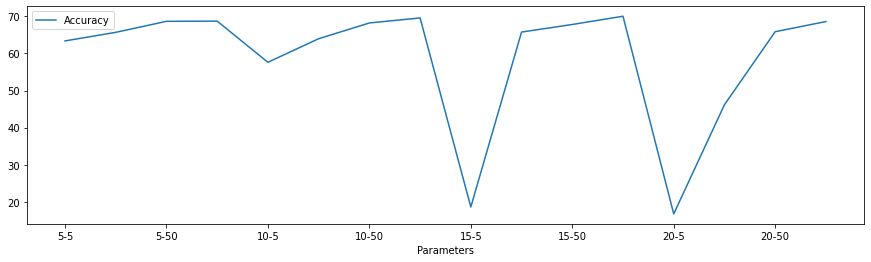

In [22]:
%matplotlib inline
ResultsData.plot(x = 'Parameters', y = 'Accuracy', figsize=(15,4), kind = 'line')

Batch size 10 and epochs = 100 results in the best accuracy

In [23]:
# Fitting the ANN to the Training set
model.fit(X_train_sup, y_train_sup ,batch_size = 10, epochs = 100, verbose=0)

# Generating Predictions on testing data
ann_pred = model.predict(X_test_sup)

# Scaling the test data back to original scale
Test_Data = PredictorScalerFit.inverse_transform(X_test_sup)

TestingData = pd.DataFrame(data = Test_Data, columns = sup_features)
TestingData['Rank'] = y_test_sup
TestingData['Predicted Rank'] = ann_pred

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_sup, ann_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_sup, ann_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_sup, ann_pred)))

Mean Absolute Error: 0.5296545986618314
Mean Squared Error: 0.4640372877869516
Root Mean Squared Error: 0.6812028242652489


### Compare Model Predictions

In [40]:
lcs_spring_2022 = pd.read_csv('LCS 2022 Spring - Player Stats - OraclesElixir.csv')

sup_lcs_2022 = lcs_spring_2022[(lcs_spring_2022['Pos'] == 'Support') & (lcs_spring_2022['GP'] >= 12)]

sup_lcs_2022 = sup_lcs_2022[['Player', 'Pos', 'GP', 'W%', 'CTR%', 'K', 'D', 'A', 'KDA', 'KP',
       'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 'CSPM', 'CS%P15', 'DPM',
       'DMG%', 'D%P15', 'EGPM', 'GOLD%', 'WPM', 'WCPM']].astype(str)

sup_lcs_2022['W%'] = sup_lcs_2022['W%'].str.replace('%', '').astype('float')
sup_lcs_2022['KS%'] = sup_lcs_2022['KS%'].str.replace('%', '').astype('float')
sup_lcs_2022['KP'] = sup_lcs_2022['KP'].str.replace('%', '').astype('float')
sup_lcs_2022['DTH%'] = sup_lcs_2022['DTH%'].str.replace('%', '').astype('float')
sup_lcs_2022['FB%'] = sup_lcs_2022['FB%'].str.replace('%', '').astype('float')
sup_lcs_2022['CS%P15'] = sup_lcs_2022['CS%P15'].str.replace('%', '').astype('float')
sup_lcs_2022['DMG%'] = sup_lcs_2022['DMG%'].str.replace('%', '').astype('float')
sup_lcs_2022['GOLD%'] = sup_lcs_2022['GOLD%'].str.replace('%', '').astype('float')

sup_lcs_2022[['GP', 'W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
      'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']] = sup_lcs_2022[['GP', 'W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
            'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']].astype('float')

sup_lcs_2022['K'] = sup_lcs_2022['K']/sup_lcs_2022['GP']
sup_lcs_2022['A'] = sup_lcs_2022['A']/sup_lcs_2022['GP']
sup_lcs_2022['D'] = sup_lcs_2022['D']/sup_lcs_2022['GP']
sup_lcs_2022.drop('GP', axis = 1, inplace = True)

means = []
for i in sup_features: 
    means.append(sup_lcs_2022[i].mean())

for j, k in enumerate(sup_features): 
    sup_lcs_2022.loc[:,k] = sup_lcs_2022[k].apply(lambda x: (x - means[j])/means[j])

X_sup_lcs_sp2022 = sup_lcs_2022[sup_features].values
sup_lcs_sp2022_names = sup_lcs_2022['Player']

PredictorScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X_sup_lcs_sp2022)
 
# Generating the standardized values of X
X_sup_lcs_sp2022 = PredictorScalerFit.transform(X_sup_lcs_sp2022)

sup_lin = lin_regressor.predict(X_sup_lcs_sp2022)
sup_dec = dec_regressor.predict(X_sup_lcs_sp2022)
sup_knn = knn_regressor.predict(X_sup_lcs_sp2022)
sup_svr = svr_regressor.predict(X_sup_lcs_sp2022)
sup_ann = model.predict(X_sup_lcs_sp2022)
final_sup_pred = (1/15*sup_knn.reshape(-1,1) + 4/15* sup_ann + 3/15*sup_dec.reshape(-1,1) + 2/15*sup_lin.reshape(-1,1) + 5/15*sup_svr.reshape(-1,1))

In [41]:
sup_lin = pd.DataFrame(sup_lin)
sup_lin.rename(columns={0:'Rank'}, inplace= True)
sup_names = sup_lcs_2022[['Player']].reset_index(drop = True)
sup_final_lin = pd.concat([sup_names, sup_lin], axis=1)
sup_final_lin.sort_values(by='Rank', ascending=True, inplace=True)
sup_final_lin.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(sup_final_lin)):
    sup_final_lin.loc[i, 'Rank'] = initial
    initial += 1

sup_final_lin

,Player,Rank
0,Winsome,1.0
1,Vulcan,2.0
2,aphromoo,3.0
3,huhi,4.0
4,Shenyi,5.0
5,Destiny,6.0
6,Poome,7.0
7,Olleh,8.0
8,Biofrost,9.0


In [42]:
sup_dec = pd.DataFrame(sup_dec)
sup_dec.rename(columns={0:'Rank'}, inplace= True)
sup_names = sup_lcs_2022[['Player']].reset_index(drop = True)
sup_final_dec = pd.concat([sup_names, sup_dec], axis=1)
sup_final_dec.sort_values(by='Rank', ascending=True, inplace=True)
sup_final_dec.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(sup_final_dec)):
    sup_final_dec.loc[i, 'Rank'] = initial
    initial += 1

sup_final_dec

,Player,Rank
0,huhi,1.0
1,Winsome,2.0
2,Shenyi,3.0
3,Olleh,4.0
4,aphromoo,5.0
5,Vulcan,6.0
6,Destiny,7.0
7,Poome,8.0
8,Biofrost,9.0


In [43]:
sup_knn = pd.DataFrame(sup_knn)
sup_knn.rename(columns={0:'Rank'}, inplace= True)
sup_names = sup_lcs_2022[['Player']].reset_index(drop = True)
sup_final_knn = pd.concat([sup_names, sup_knn], axis=1)
sup_final_knn.sort_values(by='Rank', ascending=True, inplace=True)
sup_final_knn.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(sup_final_knn)):
    sup_final_knn.loc[i, 'Rank'] = initial
    initial += 1

sup_final_knn

,Player,Rank
0,huhi,1.0
1,Shenyi,2.0
2,Winsome,3.0
3,Vulcan,4.0
4,aphromoo,5.0
5,Destiny,6.0
6,Olleh,7.0
7,Poome,8.0
8,Biofrost,9.0


In [44]:
sup_svr = pd.DataFrame(sup_svr)
sup_svr.rename(columns={0:'Rank'}, inplace= True)
sup_names = sup_lcs_2022[['Player']].reset_index(drop = True)
sup_final_svr = pd.concat([sup_names, sup_svr], axis=1)
sup_final_svr.sort_values(by='Rank', ascending=True, inplace=True)
sup_final_svr.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(sup_final_svr)):
    sup_final_svr.loc[i, 'Rank'] = initial
    initial += 1

sup_final_svr

,Player,Rank
0,Winsome,1.0
1,Vulcan,2.0
2,huhi,3.0
3,Shenyi,4.0
4,Olleh,5.0
5,aphromoo,6.0
6,Destiny,7.0
7,Biofrost,8.0
8,Poome,9.0


In [45]:
sup_ann = pd.DataFrame(sup_ann)
sup_ann.rename(columns={0:'Rank'}, inplace= True)
sup_names = sup_lcs_2022[['Player']].reset_index(drop = True)
sup_final_ann = pd.concat([sup_names, sup_ann], axis=1)
sup_final_ann.sort_values(by='Rank', ascending=True, inplace=True)
sup_final_ann.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(sup_final_ann)):
    sup_final_ann.loc[i, 'Rank'] = initial
    initial += 1

sup_final_ann

,Player,Rank
0,Winsome,1.0
1,Vulcan,2.0
2,Shenyi,3.0
3,Olleh,4.0
4,huhi,5.0
5,Poome,6.0
6,aphromoo,7.0
7,Biofrost,8.0
8,Destiny,9.0


All models outside seem reasonable. 

### Combined Results Ensemble Averaging

In [46]:
all_pred = (1/5*lin_pred.reshape(-1,1) +1/5*dec_pred.reshape(-1,1) + 1/5*svr_pred.reshape(-1,1) + 1/5*ann_pred.reshape(-1,1) + 1/5*knn_pred.reshape(-1,1))

In [47]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_sup, all_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_sup, all_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_sup, all_pred)))

Mean Absolute Error: 0.5394800290659888
Mean Squared Error: 0.4764981350322951
Root Mean Squared Error: 0.690288443357047


### Predicting for the Spring 2022 LCS Players

In [49]:
final = pd.merge(pd.merge(pd.merge(pd.merge(sup_final_lin, sup_final_knn, on = 'Player'), sup_final_svr, on = 'Player'), sup_final_dec, on = 'Player'), sup_final_ann, on = 'Player')
final['Final Rank'] = final.iloc[:].sum(axis = 1)/5
final.sort_values(by = 'Final Rank', ascending = True, inplace = True)
final

,Player,Rank_x,Rank_y,Rank_x,Rank_y,Rank,Final Rank
0,Winsome,1.0,3.0,1.0,2.0,1.0,1.6
3,huhi,4.0,1.0,3.0,1.0,5.0,2.8
1,Vulcan,2.0,4.0,2.0,6.0,2.0,3.2
4,Shenyi,5.0,2.0,4.0,3.0,3.0,3.4
2,aphromoo,3.0,5.0,6.0,5.0,7.0,5.2
7,Olleh,8.0,7.0,5.0,4.0,4.0,5.6
5,Destiny,6.0,6.0,7.0,7.0,9.0,7.0
6,Poome,7.0,8.0,9.0,8.0,6.0,7.6
8,Biofrost,9.0,9.0,8.0,9.0,8.0,8.6
